<a href="https://colab.research.google.com/github/da-vincee09/sign-language-classifiers/blob/main/ANN_Sign_Language_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sign Language Recognition using an Artificial Neural Network (ANN)**


In this notebook, we build a classifier using a basic Artificial Neural Network (ANN) to recognize hand signs representing letters from the **Sign Language MNIST** dataset.

### Background
Sign language recognition is a critical tool for improving communication accessibility for the hearing-impaired community. The **Sign Language MNIST** dataset contains images of hand signs corresponding to letters A–Y (excluding J and Z), formatted as 28×28 grayscale images. Each image represents a single hand sign.

An ANN is inspired by the structure of the human brain, consisting of layers of interconnected neurons. Unlike Convolutional Neural Networks (CNNs), which leverage spatial patterns in images, ANNs process input features in a fully connected manner. While ANNs can achieve reasonable performance on simpler image datasets, they are generally less effective than CNNs for complex image recognition tasks.

### Objectives
This notebook demonstrates a complete workflow for building, training, evaluating, and deploying an ANN for hand sign recognition. Specifically, we will:

1. **Load and preprocess the dataset**  
   * Read the training and testing CSV files containing flattened images and labels.  
   * Normalize pixel values, remove the letter 'J' from the dataset, and one-hot encode labels.

2. **Explore and visualize the data**  
   * Plot class distributions to understand dataset balance.  
   * Display sample images with their corresponding labels.

3. **Build and train an ANN model**  
   * Design a fully connected network with multiple hidden layers.  
   * Apply regularization techniques including L2 penalties, dropout, batch normalization, and label smoothing to reduce overfitting.  
   * Use early stopping and learning rate scheduling to improve training efficiency.

4. **Evaluate model performance**  
   * Measure test accuracy and loss.  
   * Plot training and validation accuracy/loss curves.  
   * Generate a confusion matrix and classification report to identify misclassifications.

5. **Test on new images**  
   * Upload external hand sign images and preprocess them to match the ANN input.  
   * Predict the corresponding letters using the trained ANN.

6. **Deploy the model with Gradio**  
   * Create an interactive interface allowing users to upload images or use a webcam to capture hand signs.  
   * Predict the ASL letter in real time and display results.

> By the end of this notebook, you will have a fully functional ANN-based hand sign recognition system capable of predicting letters from hand signs and an interactive deployment interface for real-time testing.


# **Environment Setup & Library Imports**

This notebook sets up the environment and imports all necessary libraries for the Sign Language Classification project.

- **Dependencies**: TensorFlow, Matplotlib, Seaborn, Scikit-learn, Gradio.
- **Core libraries**: `numpy`, `pandas`, `string` for data manipulation and class labels.
- **Visualization**: `matplotlib`, `seaborn` for plotting class distributions, sample images, and model performance metrics.
- **Scikit-learn**: for data splitting and evaluation using `confusion_matrix` and `classification_report`.
- **TensorFlow/Keras**: for defining, compiling, and training the ANN, using layers such as `Dense`, `BatchNormalization`, `Dropout`, `LeakyReLU`, and callbacks like `EarlyStopping`, `ReduceLROnPlateau`, and `ModelCheckpoint`.
- **Image handling**: PIL and OpenCV for preprocessing uploaded or captured hand images.
- **Gradio**: for creating an interactive interface to upload or capture hand sign images and predict the corresponding ASL letter.

> This setup ensures the notebook is fully prepared for data loading, preprocessing, model training, evaluation, visualization, and interactive prediction.


In [ ]:
# -------------------------------
# Install dependencies (only needed in Colab)
# -------------------------------
!pip install tensorflow matplotlib seaborn scikit-learn gradio --quiet

# -------------------------------
# Core libraries
# -------------------------------
import numpy as np
import pandas as pd
import string

# -------------------------------
# Visualization
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Scikit-learn for metrics & data splitting
# -------------------------------
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# -------------------------------
# TensorFlow / Keras
# -------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# -------------------------------
# Image handling and Gradio for interface
# -------------------------------
from google.colab import files
from PIL import Image, ImageOps
import cv2
import gradio as gr

# -------------------------------
# Confirm imports
# -------------------------------
print("✅ All required libraries have been successfully imported.")

✅ All required libraries have been successfully imported.


# **Load Sign Language MNIST Dataset**

- **Purpose**: Load the training and testing datasets for American Sign Language (ASL) letters (excluding J & Z for dynamic gestures).
- **Data Source**: CSV files hosted on GitHub.
  - `train_df`: Training data (~27,455 samples)
  - `test_df`: Testing data (~7,172 samples)
- **Structure**: Each row represents a flattened 28x28 grayscale image (784 pixel values) plus a `label` column indicating the ASL letter.
- **Verification**: Printing shapes of the datasets confirms successful loading.
- **Why this dataset?**  
  The **Sign Language MNIST** dataset is ideal for building a hand sign recognition model because:  
  1. **Standardized format**: All images are 28×28 grayscale, which simplifies preprocessing and allows direct use with CNNs and ANNs.  
  2. **Sufficient size**: With ~27,455 training samples and ~7,172 test samples, the dataset provides enough examples for robust model training while remaining computationally manageable.  
  3. **Realistic representation**: Each image captures a single hand sign for ASL letters A–Y (excluding J & Z), making it directly relevant for practical applications in accessibility and communication.  
  4. **Benchmarking**: Widely used in research and tutorials, it allows comparison with existing models and approaches.  
  5. **Clear labeling**: Each sample has a corresponding label, facilitating supervised learning and performance evaluation.



In [ ]:
# -------------------------------
# Load Sign Language MNIST dataset
# -------------------------------

# URLs for training and testing datasets (CSV format)
train_url = "https://raw.githubusercontent.com/minhthangdang/SignLanguageRecognition/master/sign_mnist_train.csv"
test_url  = "https://raw.githubusercontent.com/gurpreet0610/sign_language_CNN/master/sign-language-mnist/sign_mnist_test.csv"

# Read CSV files into pandas DataFrames
train_df = pd.read_csv(train_url)   # Training dataset
test_df  = pd.read_csv(test_url)    # Testing dataset

# Print dataset shapes to confirm successful loading
# Each row = 1 image (flattened 28x28 pixels + label column)
print("Training shape:", train_df.shape)  # Expected ~ (27455, 785)
print("Testing shape:", test_df.shape)    # Expected ~ (7172, 785)

Training shape: (27455, 785)
Testing shape: (7172, 785)


# **Feature Extraction and Label Preprocessing**

- **Features (`X`)**: All pixel values are extracted from the dataset by dropping the `label` column. Values are normalized to [0,1] by dividing by 255.0.
- **Labels (`y`)**: Extracted from the `label` column.

- **Class Names**: ASL letters A–Y excluding `J` and `Z` (24 classes).

- **Remove "J"**:
  - The letter `J` (label 9) is removed because it involves motion.
  - Masks are applied to filter out samples corresponding to `J`.

- **Label Mapping**:
  - Labels greater than 9 are shifted down by 1 to maintain consecutive indexing (0–23).

- **One-Hot Encoding**:
  - Labels are converted to categorical arrays for training the ANN.
  - `num_classes = 24`


In [ ]:
# --- Extract features (X) and labels (y) ---
# Drop the 'label' column to get image pixel values, normalize to [0,1] by dividing by 255
X_train = train_df.drop('label', axis=1).values / 255.0   # Training features
y_train = train_df['label'].to_numpy()                   # Training labels

# Same process for test set
X_test  = test_df.drop('label', axis=1).values / 255.0   # Test features
y_test  = test_df['label'].to_numpy()                    # Test labels

# --- Define class names (A–Y excluding J and Z) ---
import string
letters = list(string.ascii_uppercase)                   # ['A','B',...,'Z']
class_names = [l for l in letters if l not in ['J','Z']] # Keep 24 classes

# --- Remove "J" (label 9) from dataset ---
mask_train = y_train != 9
mask_test  = y_test  != 9

X_train_filtered = X_train[mask_train]
y_train_filtered = y_train[mask_train]

X_test_filtered  = X_test[mask_test]
y_test_filtered  = y_test[mask_test]

# --- Remap labels to consecutive indices 0–23 ---
# (Because after removing 'J', labels > 9 need to shift down by 1)
def map_labels(labels):
    mapped = []
    for l in labels:
        if l < 9:
            mapped.append(l)      # labels before 'J' remain the same
        elif l > 9:
            mapped.append(l-1)    # shift labels after 'J' down by 1
    return np.array(mapped)

y_train_adj = map_labels(y_train_filtered)  # Adjusted training labels
y_test_adj  = map_labels(y_test_filtered)   # Adjusted test labels

# --- One-hot encode labels for training ---
num_classes = 24
y_train_cat = to_categorical(y_train_adj, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_adj, num_classes=num_classes)

# Print shapes to verify correct preprocessing for ANN
print("ANN-ready shapes:")
print("X_train:", X_train_filtered.shape, "y_train:", y_train_cat.shape)
print("X_test:", X_test_filtered.shape, "y_test:", y_test_cat.shape)


ANN-ready shapes:
X_train: (27455, 784) y_train: (27455, 24)
X_test: (7172, 784) y_test: (7172, 24)


# **Visualizing Class Distribution and Sample Images**

- **Class Distribution**:
  - Plots the number of training samples per ASL class.
  - `x` axis: ASL letters (A–Y excluding J and Z).
  - `y` axis: Number of samples.
  - `hue` is explicitly set to avoid seaborn warnings and apply a color palette (`mako`).

- **Sample Images**:
  - Displays the first 10 training images (with a small offset for variety).
  - Each image is reshaped from a 784-dimensional vector back to 28×28 pixels.
  - Titles show the corresponding ASL class label.
  - Provides a visual check of the dataset and labels to ensure correctness.


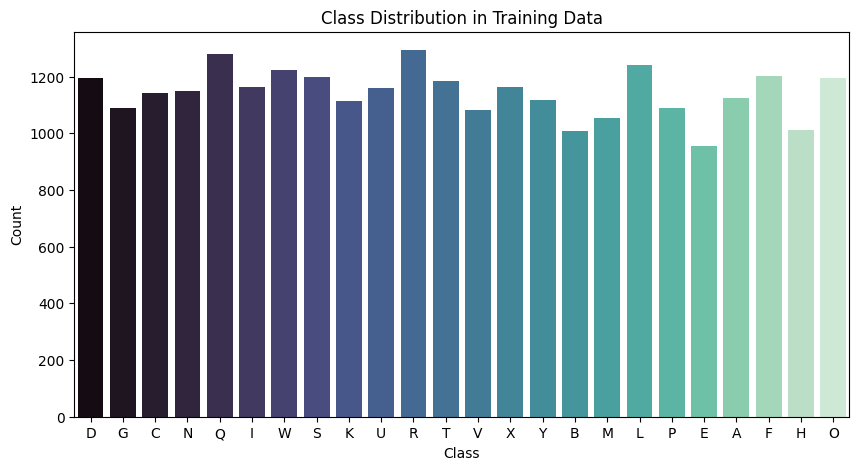

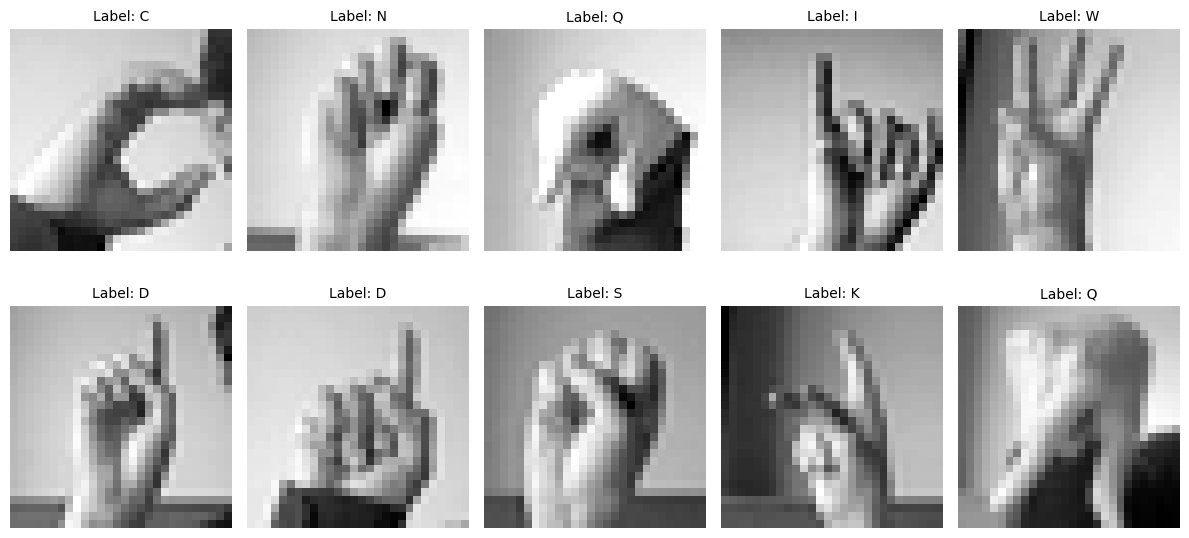

In [ ]:
# -------------------------------
# Plot class distribution
# -------------------------------
plt.figure(figsize=(10,5))

# Count how many samples exist per class in training set
# Explicitly use 'hue' to avoid FutureWarning in seaborn
sns.countplot(
    x=[class_names[i] for i in y_train_adj],   # map numeric labels to class names
    hue=[class_names[i] for i in y_train_adj], # set hue same as x to allow palette
    palette="mako",                            # color palette
    legend=False                               # no redundant legend
)

plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# -------------------------------
# Show sample images with correct labels
# -------------------------------
plt.figure(figsize=(12,6))

# Display first 10 training samples (offset by +3 for variety)
for i in range(10):
    plt.subplot(2,5,i+1)                        # 2 rows × 5 columns grid
    img = X_train_filtered[i+3].reshape(28,28)  # reshape 784 → (28,28) grayscale
    lbl = class_names[y_train_adj[i+3]]         # map numeric label → class name
    plt.imshow(img, cmap="gray")                # plot image in grayscale
    plt.title(f"Label: {lbl}", fontsize=10)     # show class as title
    plt.axis("off")                             # remove axis ticks

plt.tight_layout()
plt.show()

# **Defining and Compiling the ANN**

- **Network Architecture**:
  - Input layer: 784 features (flattened 28×28 images).
  - Three hidden layers:
    1. 512 neurons
    2. 256 neurons
    3. 128 neurons
  - Each hidden layer includes:
    - **Dense** layer with L2 regularization to prevent overfitting.
    - **LeakyReLU** activation for better gradient flow with small negative values.
    - **BatchNormalization** to stabilize and speed up training.
    - **Dropout** to randomly deactivate 20% of neurons to reduce overfitting.
  - Output layer: 24 neurons (A–Y, excluding J and Z) with **softmax** for multi-class classification.

- **Compilation**:
  - Optimizer: **Adam** with a learning rate of 0.001.
  - Loss: **CategoricalCrossentropy** with label smoothing (0.1) to reduce overconfidence.
  - Metrics: Track **accuracy** during training and validation.

- **Model Summary**:
  - Prints the model architecture, including layers, output shapes, and number of parameters.


In [ ]:
# -------------------------------
# Define ANN (simplified to reduce overfitting)
# -------------------------------
ann = Sequential([

    # Input layer for flattened 28x28 images (784 features)
    Input(shape=(784,)),

    # First hidden layer: 512 neurons
    Dense(512, kernel_regularizer=regularizers.l2(0.0005)),  # L2 regularization
    LeakyReLU(alpha=0.1),          # activation function (better than ReLU for small negatives)
    BatchNormalization(),          # normalizes activations → faster & stable training
    Dropout(0.2),                  # randomly drops 20% of neurons to reduce overfitting

    # Second hidden layer: 256 neurons
    Dense(256, kernel_regularizer=regularizers.l2(0.0005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    # Third hidden layer: 128 neurons
    Dense(128, kernel_regularizer=regularizers.l2(0.0005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    # Output layer: 24 neurons (A–Y, excluding J and Z), softmax for multi-class classification
    Dense(num_classes, activation="softmax")
])

# -------------------------------
# Compile ANN
# -------------------------------
ann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adam optimizer
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # smooths labels → reduces overconfidence
    metrics=["accuracy"]   # track accuracy during training/validation
)

# -------------------------------
# Model summary
# -------------------------------
ann.summary()   # print model architecture with parameters

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 572,824 (2.19 MB)

 Trainable params: 571,032 (2.18 MB)

 Non-trainable params: 1,792 (7.00 KB)

# **Callbacks and Training**

- **Callbacks**:
  - **EarlyStopping**: Stops training if validation loss does not improve for 10 consecutive epochs, and restores the best weights. This prevents overfitting and unnecessary computation.
  - **ReduceLROnPlateau**: If the validation loss stops improving for 3 epochs, the learning rate is reduced by 50% to allow finer adjustments to the weights.
  - **ModelCheckpoint**: Saves the best model during training based on the highest validation accuracy, allowing us to reload the best version later.

- **Training**:
  - **Input**: `X_train_filtered` and one-hot encoded labels `y_train_cat`.
  - **Validation**: `X_test_filtered` and `y_test_cat` to monitor model performance.
  - **Epochs**: Up to 100 iterations over the dataset.
  - **Batch size**: 64, which provides more frequent weight updates and better generalization.
  - **Verbose**: 1, prints training progress.
  - **Callbacks**: Applied to manage early stopping, learning rate scheduling, and model saving.

- **Reload Best Model**:
  - After training completes, the model with the highest validation accuracy (saved by `ModelCheckpoint`) is reloaded to ensure the best-performing model is used for evaluation or inference.


In [ ]:
# -------------------------------
# Callbacks
# -------------------------------
callbacks = [
    # Stop training early if validation loss doesn’t improve for 10 epochs
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),

    # Reduce learning rate by 50% if val_loss plateaus for 3 epochs
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),

    # Save the best model (based on val_accuracy) during training
    ModelCheckpoint("best_ann.keras", save_best_only=True, monitor="val_accuracy")
]

# -------------------------------
# Training
# -------------------------------
history = ann.fit(
    X_train_filtered, y_train_cat,                    # training data
    validation_data=(X_test_filtered, y_test_cat),    # validation data
    epochs=100,                                       # maximum training epochs
    batch_size=64,                                    # smaller batch → more updates → better generalization
    callbacks=callbacks,                              # apply callbacks
    verbose=1                                         # show training progress
)

# -------------------------------
# Reload Best Model
# -------------------------------
# After training, reload the best version of the model
# (with highest val_accuracy, as saved by ModelCheckpoint)
ann = load_model("best_ann.keras")

Epoch 1/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5417 - loss: 2.5321 - val_accuracy: 0.2630 - val_loss: 3.4282 - learning_rate: 0.0010
Epoch 2/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9152 - loss: 1.5101 - val_accuracy: 0.2651 - val_loss: 3.2277 - learning_rate: 0.0010
Epoch 3/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9509 - loss: 1.3241 - val_accuracy: 0.2968 - val_loss: 3.1566 - learning_rate: 0.0010
Epoch 4/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9652 - loss: 1.2078 - val_accuracy: 0.2012 - val_loss: 3.7745 - learning_rate: 0.0010
Epoch 5/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9727 - loss: 1.1205 - val_accuracy: 0.1843 - val_loss: 3.2865 - learning_rate: 0.0010
Epoch 6/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9733 - loss: 1.0762 - val_accuracy: 0.2416 - val_loss: 3.0591 - learning_rate: 0.0010
Epoch 7/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9721 -

# **Test Set Predictions and Visualization**

- **Predictions**:
  - The trained ANN outputs probability distributions over the 24 classes (A–Y excluding J and Z) for each test image.
  - `np.argmax` is used to convert these probabilities into the predicted class index.

- **Mapping Indices to Letters**:
  - Predicted indices are converted to letters using `class_names`.
  - True labels are also converted to letters for comparison.

- **Visualization**:
  - Randomly select 9 test images to display.
  - Each subplot shows the image along with its **predicted letter** and **actual letter**.
  - Axes are turned off to focus on the images and labels.
  - This helps visually assess how well the ANN is classifying unseen test data.


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


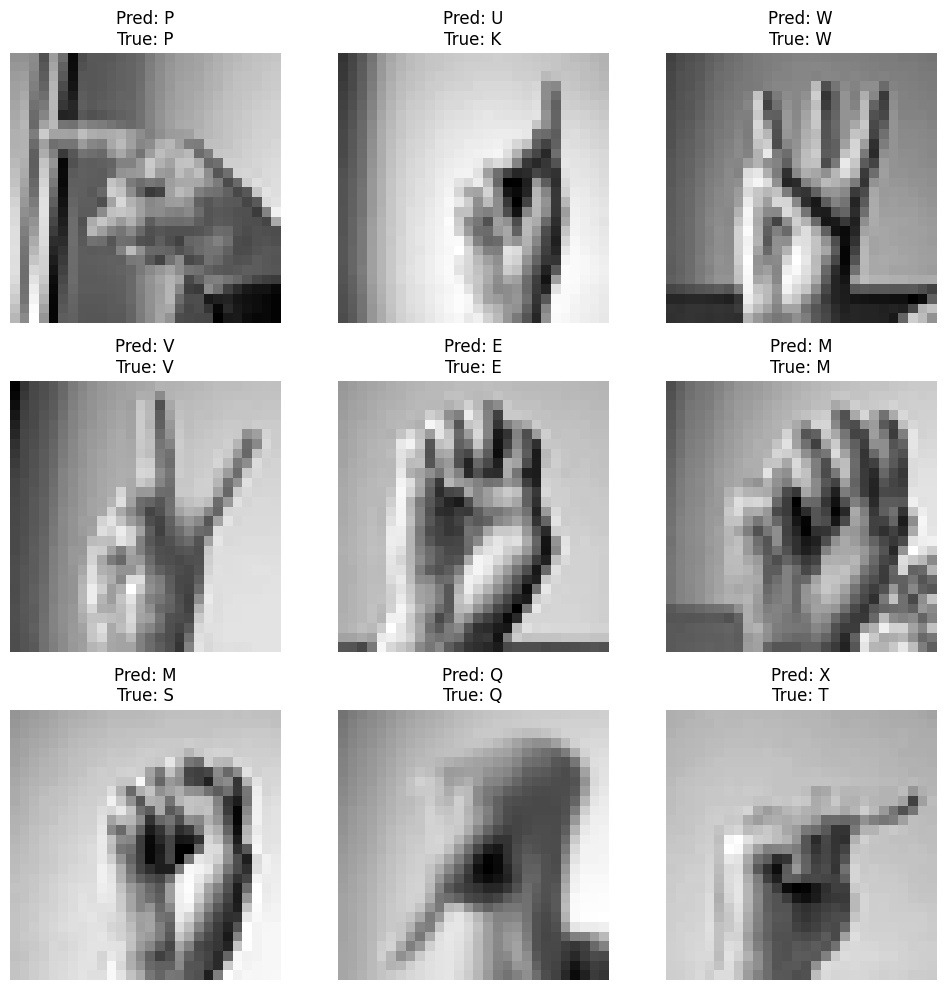

In [ ]:
# -------------------------------
# Predict on test set
# -------------------------------
predictions = ann.predict(X_test_filtered)        # ANN outputs probabilities for each class
y_pred_idx = np.argmax(predictions, axis=1)      # Convert probabilities to predicted class indices

# -------------------------------
# Convert indices to letters
# -------------------------------
pred_letters = [class_names[i] for i in y_pred_idx]   # Predicted letters
true_letters = [class_names[i] for i in y_test_adj]   # Actual letters

# -------------------------------
# Plot 9 random test samples with predictions
# -------------------------------
plt.figure(figsize=(10, 10))
# Randomly pick 9 samples from the test set
for i, idx in enumerate(np.random.choice(len(X_test_filtered), 9, replace=False)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_filtered[idx].reshape(28,28), cmap='gray')   # Display the image
    plt.title(f"Pred: {pred_letters[idx]}\nTrue: {true_letters[idx]}")  # Show predicted and actual labels
    plt.axis('off')   # Hide axes for clarity
plt.tight_layout()
plt.show()

# **Evaluate ANN Performance on Test Set**

- **Purpose**:
  - To measure how well the trained ANN generalizes to unseen data.

- **Metrics**:
  - `test_loss`: Quantifies how far off the ANN predictions are from the true labels.
  - `test_acc`: Measures the fraction of correctly predicted labels.

- **Usage**:
  - `ann.evaluate` computes both loss and accuracy on the filtered test set.
  - These results summarize overall performance and help compare with training/validation metrics.

- **Output**:
  - Loss and accuracy are printed in a readable format.
  - Example: 📉 ANN Test Loss: 1.2488, ✅ ANN Test Accuracy: 0.8249


In [ ]:
# -------------------------------
# Evaluate ANN performance on the filtered test set
# -------------------------------
test_loss, test_acc = ann.evaluate(X_test_filtered, y_test_cat, verbose=0)  # Returns loss and accuracy

# -------------------------------
# Print formatted results
# -------------------------------
print(f"📉 ANN Test Loss: {test_loss:.4f}")     # Loss on test data
print(f"✅ ANN Test Accuracy: {test_acc:.4f}")  # Accuracy on test data

📉 ANN Test Loss: 1.2304
✅ ANN Test Accuracy: 0.8162


# **Training & Validation Metrics Visualization**

- **Purpose**:
  - To visually inspect how the ANN learned over epochs.
  - Helps identify overfitting or underfitting.

- **Plots**:
  1. **Accuracy Plot (left)**:
     - Shows both training and validation accuracy per epoch.
     - Indicates how well the model predicts correctly during training and on unseen data.
  2. **Loss Plot (right)**:
     - Shows training and validation loss per epoch.
     - Lower loss indicates better model predictions; divergence between training and validation signals overfitting.

- **Usage**:
  - Analyze trends:
    - If validation accuracy plateaus or drops while training accuracy continues rising → potential overfitting.
    - Smooth decrease in both training and validation loss → good convergence.

- **Visualization**:
  - Provides an intuitive way to evaluate learning progress and effectiveness of regularization and early stopping.


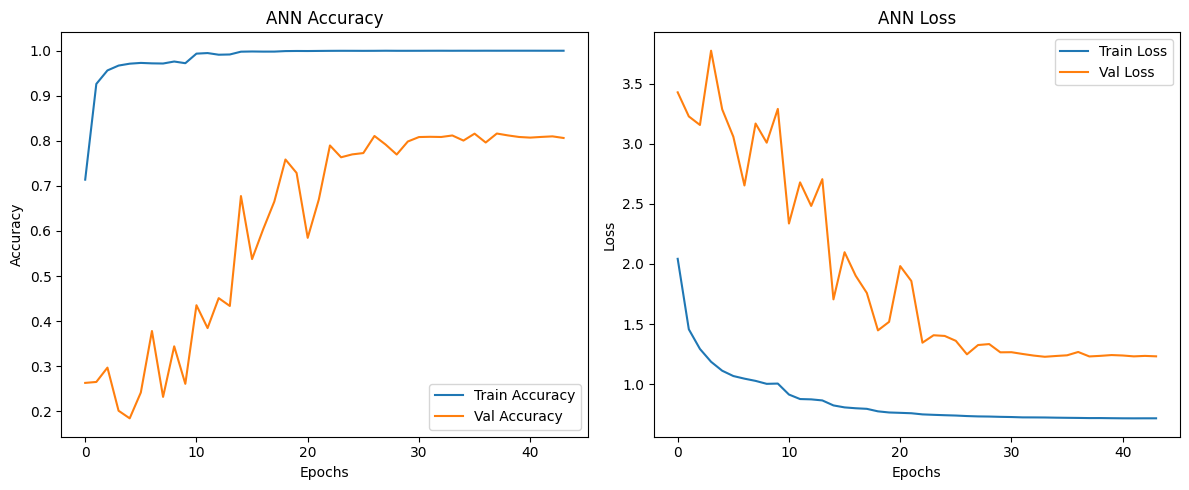

In [ ]:
# -------------------------------
# Plot Training & Validation Accuracy and Loss
# -------------------------------
plt.figure(figsize=(12,5))

# ----- Accuracy Plot -----
plt.subplot(1,2,1)  # first subplot
plt.plot(history.history['accuracy'], label="Train Accuracy")      # training accuracy per epoch
plt.plot(history.history['val_accuracy'], label="Val Accuracy")    # validation accuracy per epoch
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ANN Accuracy")
plt.legend()

# ----- Loss Plot -----
plt.subplot(1,2,2)  # second subplot
plt.plot(history.history['loss'], label="Train Loss")              # training loss per epoch
plt.plot(history.history['val_loss'], label="Val Loss")            # validation loss per epoch
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Loss")
plt.legend()

plt.tight_layout()  # adjusts spacing between subplots
plt.show()

# **Confusion Matrix & Classification Report**

- **Purpose**:
  - To evaluate the ANN's performance in detail across all 24 classes (A–Y excluding J and Z).
  - Helps identify which letters are confused with each other.

- **Confusion Matrix**:
  - Rows represent the true labels.
  - Columns represent the predicted labels.
  - Diagonal elements indicate correct predictions; off-diagonal elements indicate misclassifications.
  - The heatmap visualization allows quick spotting of which classes are frequently misclassified.

- **Classification Report**:
  - Provides metrics per class:
    - **Precision**: Fraction of correctly predicted instances among all predictions of that class.
    - **Recall**: Fraction of correctly predicted instances among all true instances of that class.
    - **F1-score**: Harmonic mean of precision and recall, balances the two.
  - **Support**: Number of true instances for each class in the test set.

- **Usage**:
  - High precision & recall across most classes indicates strong model performance.
  - Off-diagonal elements and low F1-scores point to specific letters the model struggles with, possibly due to similarity in hand shapes or insufficient training samples.


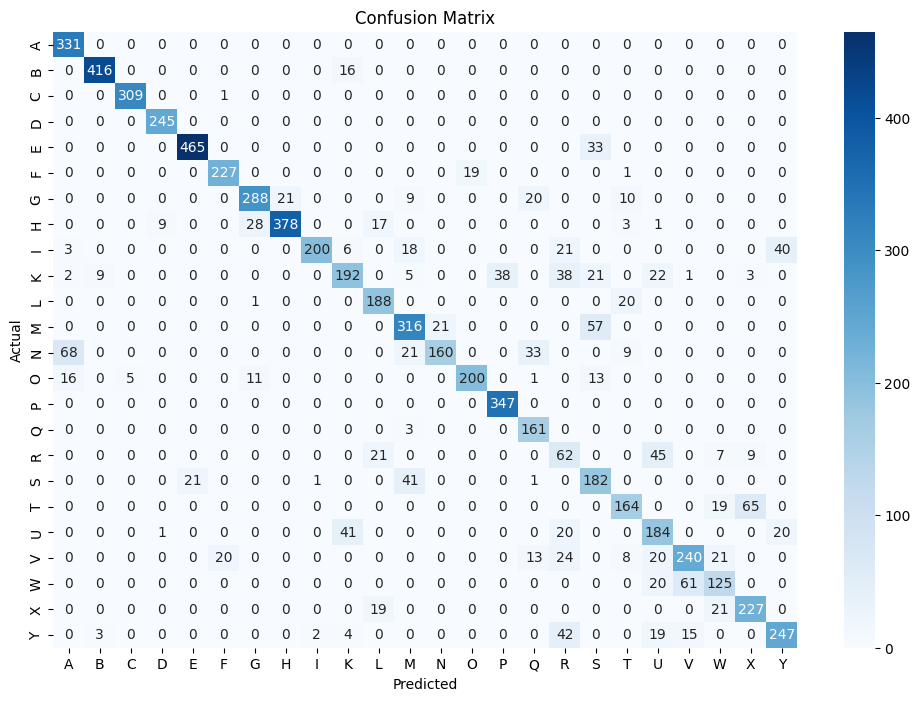

📊 Classification Report:

              precision    recall  f1-score   support

           A       0.79      1.00      0.88       331
           B       0.97      0.96      0.97       432
           C       0.98      1.00      0.99       310
           D       0.96      1.00      0.98       245
           E       0.96      0.93      0.95       498
           F       0.92      0.92      0.92       247
           G       0.88      0.83      0.85       348
           H       0.95      0.87      0.91       436
           I       0.99      0.69      0.81       288
           K       0.74      0.58      0.65       331
           L       0.77      0.90      0.83       209
           M       0.77      0.80      0.78       394
           N       0.88      0.55      0.68       291
           O       0.91      0.81      0.86       246
           P       0.90      1.00      0.95       347
           Q       0.70      0.98      0.82       164
           R       0.30      0.43      0.35       144
 

In [ ]:
# -------------------------------
# Confusion Matrix
# -------------------------------
y_true = y_test_adj                       # true labels (0–23)
y_pred = np.argmax(predictions, axis=1)   # predicted labels from ANN

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,   # predicted class labels
            yticklabels=class_names)   # true class labels
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# -------------------------------
# Classification Report
# -------------------------------
print("📊 Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,   # map indices to letter classes
    zero_division=0             # avoid division by zero warnings
))

# **Deployment: Upload and Predict**

* The trained ANN model is first saved in the modern `.keras` format using `ann.save()`. This allows it to be reloaded later without retraining.

* Users can upload any image file for prediction. The uploaded image is read using PIL (`Image.open()`).

* Preprocessing steps:  
    - Convert the image to grayscale with `convert("L")` to match the ANN input format.  
    - Check the average brightness and invert colors if the background is light, so the hand appears white on a dark background (matching the ANN training style).  
    - Apply Gaussian blur to reduce noise.  
    - Apply thresholding (binary inverted + Otsu) to segment the hand from the background.  
    - Detect the largest contour (assumed to be the hand), crop it, and pad to make a square image.  
    - Resize the image to 28×28 pixels, the same size as the training images.  
    - Flatten the image to a 1D array and normalize pixel values to the range [0,1] to prepare it for ANN input.

* Prediction:  
    - The preprocessed image is passed to `ann.predict()` to get class probabilities.  
    - `np.argmax()` is used to select the class with the highest probability.  
    - The predicted class index is mapped to the corresponding letter using `class_names`.

* The predicted class is printed, and the uploaded image is displayed for reference.


In [ ]:
# -------------------------------
# Save the trained ANN model
# -------------------------------
ann.save("ann_model.keras")  # Save the model in modern Keras format for later inference

# Prompt user to upload images for prediction
print("📂 Upload an image for prediction")
uploaded = files.upload()  # Open file upload dialog in Colab

# -------------------------------
# Preprocessing function for uploaded images
# -------------------------------
def preprocess_image(img):
    """
    Preprocess a PIL image for ANN prediction:
    1. Convert to grayscale
    2. Check average brightness and invert if background is light
    3. Apply Gaussian blur to reduce noise
    4. Apply thresholding (binary inverted + Otsu) to segment hand
    5. Find largest contour (assumed hand), crop, and pad to square
    6. Resize to 28x28
    7. Flatten and normalize pixel values to [0,1]
    """
    # Convert uploaded image to grayscale
    img_gray = img.convert("L")
    img_np = np.array(img_gray)  # Convert to NumPy array for OpenCV operations

    # Check average brightness to determine if inversion is needed
    if img_np.mean() > 127:  # If background is light, invert so hand is white
        img_np = 255 - img_np

    # Apply Gaussian blur to smooth out noise
    img_blur = cv2.GaussianBlur(img_np, (5,5), 0)

    # Apply thresholding to segment hand from background
    _, img_thresh = cv2.threshold(
        img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    # Detect contours to locate the hand
    contours, _ = cv2.findContours(
        img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    if contours:
        # Use largest contour (assumed to be the hand)
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        cropped = img_thresh[y:y+h, x:x+w]

        # Pad cropped image to square dimensions
        size = max(w,h)
        padded = np.zeros((size,size), dtype=np.uint8)
        y_offset = (size-h)//2
        x_offset = (size-w)//2
        padded[y_offset:y_offset+h, x_offset:x_offset+w] = cropped
    else:
        # Fallback if no contours found
        padded = img_thresh

    # Resize to 28x28 (input size expected by ANN)
    img_resized = cv2.resize(padded, (28,28))

    # Flatten image and normalize pixel values to range [0,1]
    img_arr = img_resized.reshape(1, 784) / 255.0
    return img_arr

# -------------------------------
# Loop through uploaded files and predict
# -------------------------------
for fn in uploaded.keys():
    # Open the uploaded image as PIL Image
    img = Image.open(fn)

    # Preprocess image to feed into ANN
    img_arr = preprocess_image(img)

    # Predict the class index using the trained ANN
    pred_idx = np.argmax(ann.predict(img_arr, verbose=0), axis=1)[0]

    # Map predicted index to corresponding letter
    pred_letter = class_names[pred_idx]

    # Display the predicted letter
    print(f"✅ Predicted Class: {pred_letter}")

    # Show the uploaded image for verification
    img.show()

📂 Upload an image for prediction


Saving Sign-language-MNIST-3.png to Sign-language-MNIST-3 (1).png
✅ Predicted Class: Y


# **Deployment: Gradio Interface for Sign Language Prediction**

* **Load Trained ANN Model**:  
   - The ANN model saved in `ann_model.keras` is loaded using `load_model()`.
   - This allows inference without retraining.

* **Class Names**:  
   - Define 24 class names representing letters A–Y, excluding J and Z.

* **Preprocessing Function**:  
   - Converts uploaded images to grayscale to match training input.  
   - Inverts colors to ensure the hand is white on a black background (as in training data).  
   - Applies Gaussian blur to reduce noise.  
   - Thresholds the image using Otsu’s method to segment the hand.  
   - Detects the largest contour (assumed to be the hand), crops it, and pads to a square.  
   - Resizes to 28×28 pixels, flattens, and normalizes pixel values to [0,1].

* **Prediction Function**:  
   - Preprocessed image is passed through `ann.predict()` to obtain class probabilities.  
   - `np.argmax()` selects the class with the highest probability.  
   - The predicted class index is mapped to the corresponding letter in `class_names`.

* **Gradio Interface**:  
   - Users can upload an image or capture one using the webcam.  
   - The interface passes the image to the prediction function and displays the predicted ASL letter.  
   - Title and description provide context to the user.


In [ ]:
# -------------------------------
# Load trained ANN model
# -------------------------------
ann = load_model("ann_model.keras")  # load saved ANN for inference

print("To use the webcam open the link for the live gradio website!\n") # instruction to use the webcam

# -------------------------------
# Define class names (24 letters: A-Y, excluding J and Z)
# -------------------------------
letters = list(string.ascii_uppercase)
class_names = [l for l in letters if l not in ['J','Z']]  # filtered 24 classes

# -------------------------------
# Preprocessing function for uploaded/captured images
# -------------------------------
def preprocess_image(img):
    """
    Preprocess a PIL image for ANN prediction:
    1. Convert to grayscale
    2. Invert colors so hand is white
    3. Apply Gaussian blur to reduce noise
    4. Threshold to segment hand from background
    5. Find largest contour (assumed hand) and crop
    6. Pad to square and resize to 28x28
    7. Flatten and normalize to [0,1] for ANN input
    """
    # Convert image to grayscale
    img_gray = img.convert("L")
    img_gray = ImageOps.invert(img_gray)  # Ensure hand is white

    # Convert to numpy array for OpenCV processing
    img_np = np.array(img_gray)

    # Apply Gaussian blur
    img_blur = cv2.GaussianBlur(img_np, (5,5), 0)

    # Apply Otsu threshold (binary inverted: hand white, background black)
    _, img_thresh = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours in thresholded image
    contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Use largest contour as the hand
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)

        # Crop the hand region
        cropped = img_thresh[y:y+h, x:x+w]

        # Pad to square
        size = max(w, h)
        padded = np.zeros((size, size), dtype=np.uint8)
        y_offset = (size - h) // 2
        x_offset = (size - w) // 2
        padded[y_offset:y_offset+h, x_offset:x_offset+w] = cropped
    else:
        padded = img_thresh  # fallback if no contour found

    # Resize to 28x28
    img_resized = cv2.resize(padded, (28,28))

    # Flatten and normalize to [0,1]
    img_arr = img_resized.reshape(1, 784) / 255.0

    return img_arr

# -------------------------------
# Prediction function
# -------------------------------
def predict_image(img):
    """
    Takes a PIL image, preprocesses it, and predicts the ASL letter using the ANN.
    Returns the predicted letter as string.
    """
    img_arr = preprocess_image(img)
    pred_idx = np.argmax(ann.predict(img_arr, verbose=0), axis=1)[0]  # get predicted class index
    return class_names[pred_idx]  # map index to letter

# -------------------------------
# Gradio Interface
# -------------------------------
gr.Interface(
    fn=predict_image,  # function to run for prediction
    inputs=gr.Image(type="pil", sources=["upload", "webcam"]),  # image input via upload or webcam
    outputs="text",  # output is predicted letter
    title="🖐 Sign Language Classifier",
    description="Upload or capture a hand sign. The ANN will preprocess the hand image and predict the corresponding ASL letter."
).launch()

To use the webcam open the link for the live gradio website!

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://74095f639f7efa5a5e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Conclusion & Future Recommendations**

* **Model Performance**:  
   - The ANN achieved a **test accuracy in the range of 80–83%**, demonstrating reasonable performance in recognizing hand signs from the Sign Language MNIST dataset.  
   - This indicates that the network learned meaningful patterns from the pixel values despite being a fully connected network without spatial feature extraction.

* **Strengths**:  
   - The model benefits from **preprocessing** (normalization, label filtering, and one-hot encoding), which standardizes the input and improves learning.  
   - **Dropout layers, batch normalization, and L2 regularization** reduced overfitting and stabilized training.  
   - **Label smoothing** in the loss function helped prevent overconfident predictions and improved generalization.

* **Limitations**:  
   - Fully connected ANNs are limited in capturing **spatial hierarchies** of the hand shapes, which are critical for distinguishing visually similar letters.  
   - Misclassifications mainly occur between letters with **similar hand gestures** (e.g., A vs. S or M vs. N).  
   - Performance is also affected by **variations in hand orientation, lighting, and background** in the input images.

* **Recommendations for Improvement**:  
   - **Convolutional Neural Networks (CNNs)** are better suited for image data since they can automatically learn spatial features like edges, contours, and shapes.  
   - Data augmentation (rotation, scaling, translation) can help the network generalize better to unseen hand positions.  
   - Hyperparameter tuning (learning rate, batch size, number of layers/neurons) and larger datasets can further improve accuracy.  
   - With these enhancements, it is reasonable to expect **accuracy improvements to 90–95%**.

* **Final Remark**:  
   - While the ANN provides a solid baseline, **CNN-based architectures** are recommended for production-grade sign language recognition systems due to their superior ability to model image patterns.
